In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar datos

In [37]:
def LeerDataset():
    data = pd.read_csv("./output_with_malware_filtered.csv", encoding="utf-8", na_values="?", low_memory=False, on_bad_lines='skip')
    return data

data = LeerDataset()

# Eliminar columnas no relevantes

In [38]:
data = data.drop(columns=['Pre_static_analysis.Filename', 
                          "Static_analysis.Package name",
                          'Pre_static_analysis.md5', 
                          'Pre_static_analysis.sha256', 
                          'Pre_static_analysis.sha1'])
filas, columnas = data.shape
df = data
print(filas)
print(columnas)

428
24197


# De 193 a 20 Opcodes

In [39]:
# Filtrar las columnas que empiezan con 'Static_analysis.Opcodes'
static_opcodes_columns = data.filter(like='Static_analysis.Opcodes').columns.tolist()
# Contar cuántas columnas hay
count_static_opcodes = len(static_opcodes_columns)
# Mostrar la cantidad de columnas encontradas
print(f"Cantidad de columnas que empiezan con 'Static_analysis.Opcodes': {count_static_opcodes}")


Cantidad de columnas que empiezan con 'Static_analysis.Opcodes': 193


In [40]:
import re
# Top Opcodes 20
opcodes_list = ['Static_analysis.Opcodes.const/16', 'Static_analysis.Opcodes.const/4', 'Static_analysis.Opcodes.goto', 
                'Static_analysis.Opcodes.if-eqz', 'Static_analysis.Opcodes.if-nez', 'Static_analysis.Opcodes.invoke-direct', 
                'Static_analysis.Opcodes.invoke-static', 'Static_analysis.Opcodes.invoke-super', 'Static_analysis.Opcodes.invoke-virtual',
            'Static_analysis.Opcodes.move-exception', 'Static_analysis.Opcodes.move-result', 'Static_analysis.Opcodes.move-result-object', 
            'Static_analysis.Opcodes.new-array', 'Static_analysis.Opcodes.new-instance', 'Static_analysis.Opcodes.return-object',
            'Static_analysis.Opcodes.return-void', 'Static_analysis.Opcodes.sget-object', 'Static_analysis.Opcodes.sput-object', 
            'Static_analysis.Opcodes.aput-object', 'Static_analysis.Opcodes.const-wide/16', 'Static_analysis.Opcodes.throw',
                'Static_analysis.Opcodes.move-object']


# Filtrar las columnas de opcodes que existen en el dataset
all_opcodes_columns = [col for col in data.columns if 'Opcodes' in col]

# Identificar las columnas de opcodes que NO están en la lista de opcodes permitidos
columns_to_remove = [col for col in all_opcodes_columns if col not in opcodes_list]

# Eliminar solo las columnas de opcodes que no están en la lista de opcodes_list
filtered_data = data.drop(columns=columns_to_remove)
data = filtered_data

In [41]:
# Filtrar las columnas que empiezan con 'Static_analysis.Opcodes'
static_opcodes_columns = data.filter(like='Static_analysis.Opcodes').columns.tolist()
# Contar cuántas columnas hay
count_static_opcodes = len(static_opcodes_columns)
# Mostrar la cantidad de columnas encontradas
print(f"Cantidad de columnas que empiezan con 'Static_analysis.Opcodes': {count_static_opcodes}")


Cantidad de columnas que empiezan con 'Static_analysis.Opcodes': 22


In [42]:
filas, columnas = data.shape
print(filas)
print(columnas)

428
24026


# De 167 permisos a 27

In [43]:
df = filtered_data
# Convertir las listas de permisos de cada fila en listas reales
df['Static_analysis.Permissions'] = df['Static_analysis.Permissions'].apply(lambda x: eval(x))

# Crear un conjunto vacío para almacenar los permisos únicos
permisos_unicos = set()

# Recorrer cada fila y agregar los permisos al conjunto
df['Static_analysis.Permissions'].apply(lambda permisos: permisos_unicos.update(permisos))

# Contar cuántos permisos únicos hay
total_permisos_unicos = len(permisos_unicos)

# Imprimir el total y los permisos únicos
print(f"Total de tipos diferentes de permisos: {total_permisos_unicos}")
# print(f"Permisos únicos: {permisos_unicos}")

Total de tipos diferentes de permisos: 167


In [44]:
df['Static_analysis.Permissions']

0      [android.permission.INTERNET, android.permissi...
1      [android.permission.WRITE_EXTERNAL_STORAGE, an...
2      [android.permission.WRITE_EXTERNAL_STORAGE, an...
3      [android.permission.WRITE_EXTERNAL_STORAGE, an...
4      [android.permission.GET_TASKS, android.permiss...
                             ...                        
423    [android.permission.INTERNET, android.permissi...
424    [android.permission.WRITE_EXTERNAL_STORAGE, an...
425    [android.permission.ACCESS_NETWORK_STATE, andr...
426    [android.permission.ACCESS_WIFI_STATE, android...
427    [android.permission.INTERNET, android.permissi...
Name: Static_analysis.Permissions, Length: 428, dtype: object

In [45]:
# Contar cuántas columnas tienen la palabra "permission"
columnas_permission = [col for col in df.columns if 'android.permission' in col]

# Imprimir el nombre de las columnas
print("Columnas que contienen la palabra 'permission':")
for col in columnas_permission:
    print(col)

# Imprimir cuántas columnas contienen "permission"
print(f"Hay {len(columnas_permission)} columnas que contienen la palabra 'permission'.")
data = df

Columnas que contienen la palabra 'permission':
Static_analysis.Strings.android.permission.READ_PHONE_STATE
Static_analysis.Strings.android.permission.ACCESS_WIFI_STATE
Static_analysis.Strings.android.permission.ACCESS_NETWORK_STATE
Static_analysis.Strings.android.permission.ACCESS_COARSE_LOCATION
Static_analysis.Strings.android.permission.ACCESS_FINE_LOCATION
Static_analysis.Strings.android.permission.INTERNET
Hay 6 columnas que contienen la palabra 'permission'.


In [46]:
#data["android.permission.READ_PHONE_STATE"].unique()

KeyError: 'android.permission.READ_PHONE_STATE'

# Dynamic Analysis

In [13]:

# 1. Identificar las columnas que comienzan con 'Dynamic_analysis.Droidbox.fdaccess' y 'Dynamic_analysis.Droidbox.dexclass'
fdaccess_cols = [col for col in data.columns if 'fdaccess' in col]
dexclass_cols = [col for col in data.columns if 'dexclass' in col]
accessedfiles_cols = [col for col in data.columns if 'accessedfiles' in col]

# 2. Crear nuevas columnas simplificadas
data['Dynamic_analysis.Droidbox.fdaccess'] = np.nan
data['Dynamic_analysis.Droidbox.dexclass'] = np.nan
data['Dynamic_analysis.Droidbox.accessedfiles'] = np.nan

# 3. Rellenar las nuevas columnas con la combinación de valor y el sufijo del nombre de columna
for col in fdaccess_cols:
    index = data[col].first_valid_index()
    if index is not None:
        value = data.at[index, col]
        suffix = '.'.join(col.split('.')[3:])  # Extrae el resto del nombre de la columna
        new_value = f"{value} + {suffix}"
        data.at[index, 'Dynamic_analysis.Droidbox.fdaccess'] = new_value
        #print("el nuevo valor es", new_value)

for col in dexclass_cols:
    index = data[col].first_valid_index()
    if index is not None:
        value = data.at[index, col]
        suffix = '.'.join(col.split('.')[3:])
        new_value = f"{value} + {suffix}"
        data.at[index, 'Dynamic_analysis.Droidbox.dexclass'] = new_value
        #print("el nuevo valor es", new_value)

for col in accessedfiles_cols:
    index = data[col].first_valid_index()
    if index is not None:
        value = data.at[index, col]
        suffix = '.'.join(col.split('.')[3:])
        new_value = f"{value} + {suffix}"
        data.at[index, 'Dynamic_analysis.Droidbox.accessedfiles'] = new_value
        #print("el nuevo valor es", new_value)

# 4. Eliminar las columnas originales que ya no son necesarias
data = data.drop(columns=fdaccess_cols + dexclass_cols)

# 5. Mostrar el resultado
print(data)


/tmp/ipykernel_12062/3366413866.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '/proc/33/cmdline + 7.016025066375732.path' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, 'Dynamic_analysis.Droidbox.fdaccess'] = new_value
/tmp/ipykernel_12062/3366413866.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '/data/app/jp.waraerudouga-1.apk + 0.6662881374359131.path' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, 'Dynamic_analysis.Droidbox.dexclass'] = new_value
/tmp/ipykernel_12062/3366413866.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '/proc/27/cmdline + 617628131' has dtype incompatible with float64, please explicit

     Static_analysis.Opcodes.move-object  Static_analysis.Opcodes.return-void  \
0                                   12.0                                 24.0   
1                                  110.0                                481.0   
2                                  251.0                                481.0   
3                                  690.0                               3038.0   
4                                  269.0                                552.0   
..                                   ...                                  ...   
423                                402.0                                  NaN   
424                                142.0                                 22.0   
425                                 11.0                                  NaN   
426                                 19.0                                  3.0   
427                                  5.0                                  NaN   

     Static_analysis.Opcode

In [14]:

# Seleccionar solo las columnas que empiezan con 'Dynamic_analysis.Droidbox.accessedfiles'
accessedfiles_columns = [col for col in data.columns if col.startswith('Dynamic_analysis.Droidbox.accessedfiles')]

# Crear un DataFrame con solo las columnas seleccionadas
accessedfiles_df = data[accessedfiles_columns]

# Utilizar stack() para aplanar el DataFrame y eliminar valores NaN
stacked = accessedfiles_df.stack()

# Crear una nueva columna con el número específico de cada columna + valor
stacked.index = stacked.index.map(lambda x: f"{x[1].split('.')[-1]}: {stacked.loc[x]}")

# Agrupar los valores por la fila original (primer índice)
combined_values = stacked.groupby(level=0).apply(lambda x: ', '.join(x))

# Crear el DataFrame final con la nueva columna
data['Dynamic_analysis.Droidbox.accessedfiles'] = combined_values


# Eliminar las columnas originales
data.drop(accessedfiles_columns, axis=1, inplace=True)

# Mostrar el DataFrame resultante
print(data)

     Static_analysis.Opcodes.move-object  Static_analysis.Opcodes.return-void  \
0                                   12.0                                 24.0   
1                                  110.0                                481.0   
2                                  251.0                                481.0   
3                                  690.0                               3038.0   
4                                  269.0                                552.0   
..                                   ...                                  ...   
423                                402.0                                  NaN   
424                                142.0                                 22.0   
425                                 11.0                                  NaN   
426                                 19.0                                  3.0   
427                                  5.0                                  NaN   

     Static_analysis.Opcode

In [15]:

# Imprimir strings
string_columns = data.select_dtypes(include=['object']).columns

# Imprimir los nombres de las colu
# Convertir a 1 donde hay datos (no NaN o vacío) y 0 donde no hay
binary_data = data.notna().astype(int)

# En caso de que también quieras tratar los strings vacíos como datos ausentes
binary_data = binary_data.where(data != '', 0)

# Mostrar el DataFrame binario
print(binary_data) # mnas que contienen strings
print(string_columns)

     Static_analysis.Opcodes.move-object  Static_analysis.Opcodes.return-void  \
0                                      1                                    1   
1                                      1                                    1   
2                                      1                                    1   
3                                      1                                    1   
4                                      1                                    1   
..                                   ...                                  ...   
423                                    1                                    0   
424                                    1                                    1   
425                                    1                                    0   
426                                    1                                    1   
427                                    1                                    0   

     Static_analysis.Opcode

In [16]:

# Convertir a 1 donde hay datos (no NaN o vacío) y 0 donde no hay
binary_data = data.notna().astype(int)

# En caso de que también quieras tratar los strings vacíos como datos ausentes
binary_data = binary_data.where(data != '', 0)

# Mostrar el DataFrame binario
print(binary_data)
data = binary_data
df = data

     Static_analysis.Opcodes.move-object  Static_analysis.Opcodes.return-void  \
0                                      1                                    1   
1                                      1                                    1   
2                                      1                                    1   
3                                      1                                    1   
4                                      1                                    1   
..                                   ...                                  ...   
423                                    1                                    0   
424                                    1                                    1   
425                                    1                                    0   
426                                    1                                    1   
427                                    1                                    0   

     Static_analysis.Opcode

In [17]:

# Convertir las columnas a numérico
data = data.apply(pd.to_numeric, errors='coerce')


In [18]:
print(data.shape)

(428, 10139)


In [19]:
print(data.head())

   Static_analysis.Opcodes.move-object  Static_analysis.Opcodes.return-void  \
0                                    1                                    1   
1                                    1                                    1   
2                                    1                                    1   
3                                    1                                    1   
4                                    1                                    1   

   Static_analysis.Opcodes.if-eqz  Static_analysis.Opcodes.invoke-static  \
0                               1                                      1   
1                               1                                      1   
2                               1                                      1   
3                               1                                      1   
4                               1                                      1   

   Static_analysis.Opcodes.const/4  Static_analysis.Opcodes.move-exc

In [20]:
# Definir el porcentaje mínimo de valores no nulos que debe tener una columna para mantenerse
threshold = len(data) * 0.4  # 40% de datos no vacíos, significa que más del 60% puede ser NaN

# Eliminar columnas con más del 60% de valores vacíos
data_cleaned = data.dropna(axis=1, thresh=threshold)

# Mostrar el DataFrame limpio
print(data_cleaned.shape)

(428, 10139)


In [21]:
df.to_csv('out-231024.csv', index=False)

###########################################################################################################
# ML
###########################################################################################################

In [22]:

# Reemplazar cualquier valor NaN que no se pudo convertir por 0
#data.fillna(0, inplace=True)


def CargarYprepararDatos(data):
    #data['Pre_static_analysis.Filename'] = data['Pre_static_analysis.Filename'].str.split('.').str[0]
    test = data.apply(pd.to_numeric, errors='coerce')
    data = test
    X = data.drop("malware", axis=1)
    y = data["malware"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [23]:
X_train, X_test, y_train, y_test = CargarYprepararDatos(data)

In [24]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-10-31 08:01:23.618796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 08:01:23.635914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 08:01:23.640541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 08:01:23.651999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 08:01:24.572608: W tensorflow/compiler/tf2

In [25]:
data

,Static_analysis.Opcodes.move-object,Static_analysis.Opcodes.return-void,Static_analysis.Opcodes.if-eqz,Static_analysis.Opcodes.invoke-static,Static_analysis.Opcodes.const/4,Static_analysis.Opcodes.move-exception,Static_analysis.Opcodes.invoke-super,Static_analysis.Opcodes.invoke-virtual,Static_analysis.Opcodes.move-result-object,Static_analysis.Opcodes.goto,...,android.permission.WRITE_SETTINGS,android.permission.GET_ACCOUNTS,android.permission.INSTALL_SHORTCUT,android.permission.GET_TASKS,android.permission.WRITE_SMS,android.permission.READ_EXTERNAL_STORAGE,android.permission.CAMERA,android.permission.SYSTEM_ALERT_WINDOW,Dynamic_analysis.Droidbox.fdaccess,Dynamic_analysis.Droidbox.dexclass
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
424,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,0,0
425,1,0,1,1,0,1,0,0,0,1,...,1,1,1,1,1,1,1,1,0,0
426,1,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,0


In [26]:
filas, columnas = data.shape
print(filas)
print(columnas)

428
10139


In [27]:
def crearModeloML():
    # Crear un modelo simple
    model = Sequential([
        Dense(columnas, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(int(columnas/2), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    
    # Entrenar el modelo
    modelHistory = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    return model, modelHistory
    

In [28]:
model, modelHistory = crearModeloML()

/home/c7032681/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-31 08:01:26.683717: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - AUC: 0.6186 - Precision: 0.5693 - Recall: 0.5381 - accuracy: 0.6248 - loss: 19.2469 - val_AUC: 0.9068 - val_Precision: 0.7297 - val_Recall: 0.9643 - val_accuracy: 0.8406 - val_loss: 0.8575
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.8805 - Precision: 0.8166 - Recall: 0.7778 - accuracy: 0.8231 - loss: 0.7777 - val_AUC: 0.9460 - val_Precision: 0.7179 - val_Recall: 1.0000 - val_accuracy: 0.8406 - val_loss: 0.7954
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.9666 - Precision: 0.8046 - Recall: 0.9316 - accuracy: 0.8672 - loss: 0.3751 - val_AUC: 0.9878 - val_Precision: 0.9259 - val_Recall: 0.8929 - val_accuracy: 0.9275 - val_loss: 0.1851
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.9816 - Precision: 0.9553 - Recall: 0.8870 - accuracy: 0.9380 - loss: 0.1876 - val_AUC: 0.9495 - val_Precision: 0.9000 - val_Recall: 0.9643 - val_accuracy: 0.9420 - val_loss: 0.4732
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

In [29]:
model

<Sequential name=sequential, built=True>

/home/c7032681/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


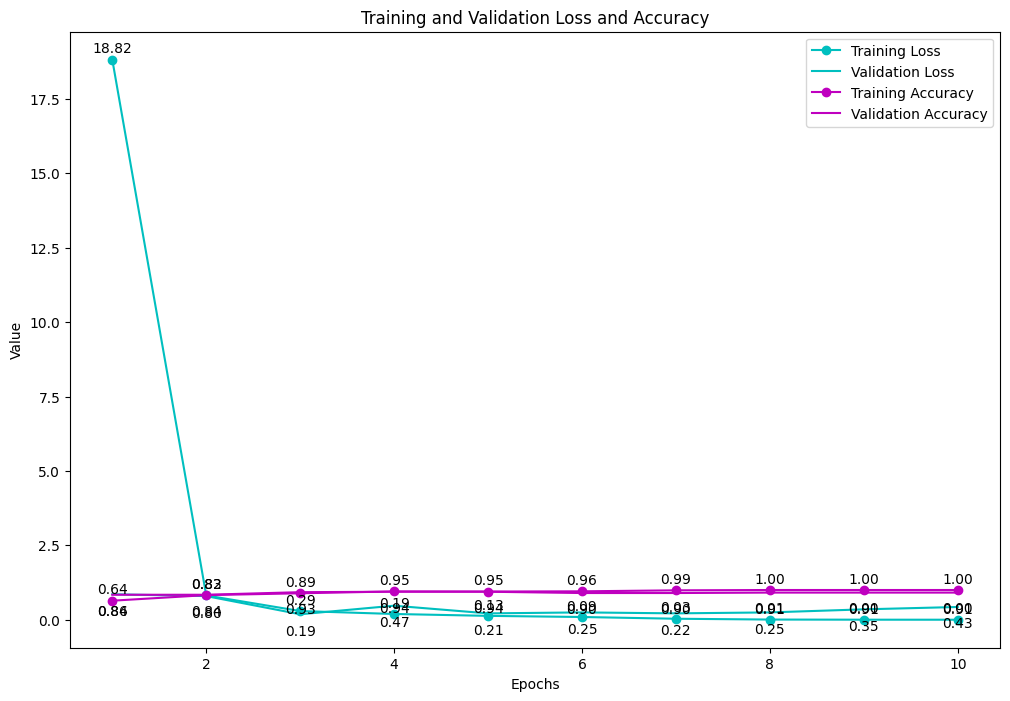

In [30]:
import matplotlib.pyplot as plt
# Obtener los datos del entrenamiento y la validación
history_dict = modelHistory.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Crear una figura
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(12, 8))

# Gráfico de Loss
plt.plot(epochs, loss, 'co-', label='Training Loss')
plt.plot(epochs, val_loss, 'c-', label='Validation Loss')

# Añadir anotaciones para Loss
for i, (l, vl) in enumerate(zip(loss, val_loss), 1):
    plt.annotate(f'{l:.2f}', (i, l), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.annotate(f'{vl:.2f}', (i, vl), textcoords="offset points", xytext=(0, -15), ha='center')

# Gráfico de Accuracy en el mismo gráfico
plt.plot(epochs, accuracy, 'mo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'm-', label='Validation Accuracy')

# Añadir anotaciones para Accuracy
for i, (a, va) in enumerate(zip(accuracy, val_accuracy), 1):
    plt.annotate(f'{a:.2f}', (i, a), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.annotate(f'{va:.2f}', (i, va), textcoords="offset points", xytext=(0, -15), ha='center')

# Añadir títulos y etiquetas
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Mostrar el gráfico
plt.show()

In [31]:
# Obtener los datos del entrenamiento y la validación
history_dict = modelHistory.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
# precision = history_dict['precision']
# val_precision = history_dict['val_precision']
# recall = history_dict['recall']
# val_recall = history_dict['val_recall']
# auc = history_dict['auc']
# val_auc = history_dict['val_auc']

In [32]:

# Obtener el accuracy y loss de entrenamiento y validación
accuracy_train = modelHistory.history['accuracy']
loss_train = modelHistory.history['loss']
accuracy_val = modelHistory.history['val_accuracy']
loss_val = modelHistory.history['val_loss']

# Calcular el promedio del accuracy y loss
avg_accuracy_train = sum(accuracy_train) / len(accuracy_train)
avg_loss_train = sum(loss_train) / len(loss_train)
avg_accuracy_val = sum(accuracy_val) / len(accuracy_val)
avg_loss_val = sum(loss_val) / len(loss_val)

print("Promedio de Accuracy (entrenamiento):", avg_accuracy_train)
print("Promedio de Loss (entrenamiento):", avg_loss_train)
print("Promedio de Accuracy (validación):", avg_accuracy_val)
print("Promedio de Loss (validación):", avg_loss_val)

Promedio de Accuracy (entrenamiento): 0.9205128252506256
Promedio de Loss (entrenamiento): 2.0394110558438117
Promedio de Accuracy (validación): 0.9028985619544982
Promedio de Loss (validación): 0.4016495019197464


# FGSM

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [15]:

# Implementar FGSM
def fgsm_attack(model, loss_object, image, label, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    
    return adversarial_image


# Configurar la pérdida
loss_object = tf.keras.losses.BinaryCrossentropy()

# Seleccionar una muestra del conjunto de prueba para el ataque adversario
sample_index = 3
sample_image = tf.convert_to_tensor([X_test.iloc[sample_index]], dtype=tf.float32)
sample_label = tf.convert_to_tensor([y_test.iloc[sample_index]], dtype=tf.float32)

# Realizar el ataque FGSM
epsilon = 0.1
adversarial_image = fgsm_attack(model, loss_object, sample_image, sample_label, epsilon)

# Evaluar la imagen adversaria
pred_original = model.predict(sample_image)
pred_adversarial = model.predict(adversarial_image)

print("Predicción original:", pred_original)
print("Predicción adversaria:", pred_adversarial)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicción original: [[0.9976271]]
Predicción adversaria: [[1.16301406e-10]]


/home/b7032681/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ops.EagerTensor(value, ctx.device_name, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

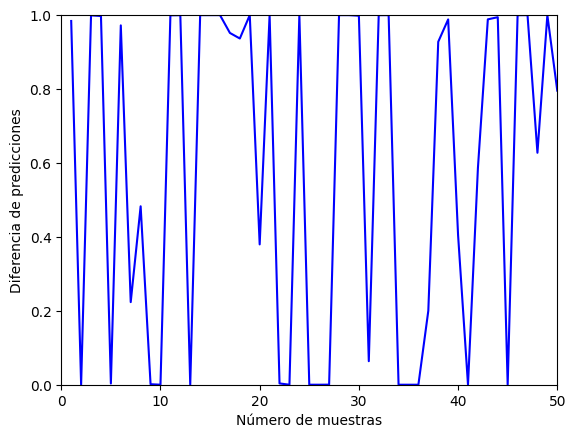

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Configurar la pérdida
loss_object = tf.keras.losses.BinaryCrossentropy()

# Parámetro de perturbación
epsilon = 0.1

# Variables para almacenar resultados
original_predictions = []
adversarial_predictions = []

# Generar y evaluar 1000 muestras adversarias
num_samples = 50

# Configurar la gráfica
plt.ion()  # Modo interactivo
fig, ax = plt.subplots()
x_data = []
y_data = []

line, = ax.plot(x_data, y_data, 'b-')
ax.set_xlim(0, num_samples)
ax.set_ylim(0, 1)  # Ajusta según la escala de las predicciones
ax.set_xlabel('Número de muestras')
ax.set_ylabel('Diferencia de predicciones')

for i in range(num_samples):
    sample_image = tf.convert_to_tensor([X_test.iloc[i]], dtype=tf.float32)
    sample_label = tf.convert_to_tensor([y_test.iloc[i]], dtype=tf.float32)
    
    adversarial_image = fgsm_attack(model, loss_object, sample_image, sample_label, epsilon)
    
    pred_original = model.predict(sample_image)
    pred_adversarial = model.predict(adversarial_image)
    
    original_predictions.append(pred_original)
    adversarial_predictions.append(pred_adversarial)
    
    # Calcula la diferencia entre las predicciones originales y adversarias
    diff = np.abs(pred_original - pred_adversarial).mean()
    
    # Actualiza los datos de la gráfica
    x_data.append(i + 1)
    y_data.append(diff)
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    
    # Redibuja la gráfica
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    # Print opcional para debug
    # print(f"Muestra {i+1}/{num_samples}")
    # print("Predicción original:", pred_original)
    # print("Predicción adversaria:", pred_adversarial)

# Convertir los resultados a arrays numpy para análisis posterior
original_predictions = np.array(original_predictions)
adversarial_predictions = np.array(adversarial_predictions)

# Aquí puedes agregar código para analizar los resultados


Pérdida original: 0.005992547
Pérdida adversaria: 6.202716
Accuracy original: 1.0
Accuracy adversaria: 0.42


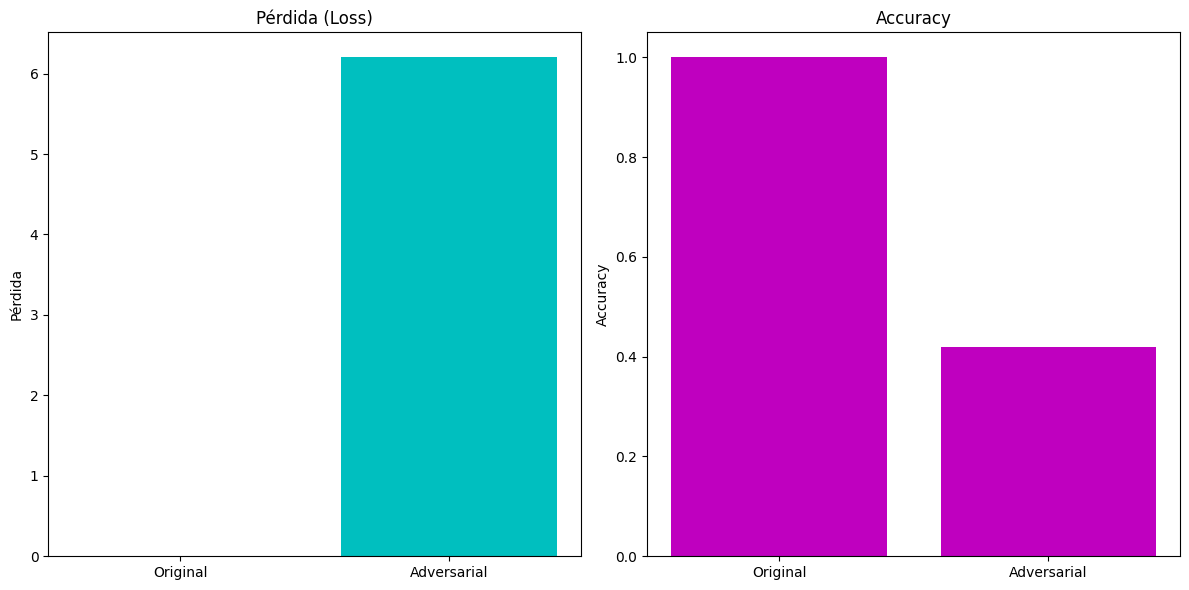

In [17]:
# Convertir los resultados a arrays numpy para análisis posterior
original_predictions = np.array(original_predictions).flatten()
adversarial_predictions = np.array(adversarial_predictions).flatten()

# Calcular la pérdida y el accuracy para las predicciones originales y adversarias
y_test_sampled = y_test.iloc[:num_samples].values

loss_original = loss_object(y_test_sampled, original_predictions).numpy()
loss_adversarial = loss_object(y_test_sampled, adversarial_predictions).numpy()

accuracy_original = np.mean((original_predictions > 0.5).astype(int) == y_test_sampled)
accuracy_adversarial = np.mean((adversarial_predictions > 0.5).astype(int) == y_test_sampled)

print("Pérdida original:", loss_original)
print("Pérdida adversaria:", loss_adversarial)
print("Accuracy original:", accuracy_original)
print("Accuracy adversaria:", accuracy_adversarial)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.bar(['Original', 'Adversarial'], [loss_original, loss_adversarial], color="c")
plt.title('Pérdida (Loss)')
plt.ylabel('Pérdida')

# Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Original', 'Adversarial'], [accuracy_original, accuracy_adversarial], color="m")
plt.title('Accuracy')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Pérdida original: 0.00060675084
Pérdida adversaria: 5.783401
Accuracy original: 1.0
Accuracy adversaria: 0.4
F1 Score original: 1.0
F1 Score adversaria: 0.0625


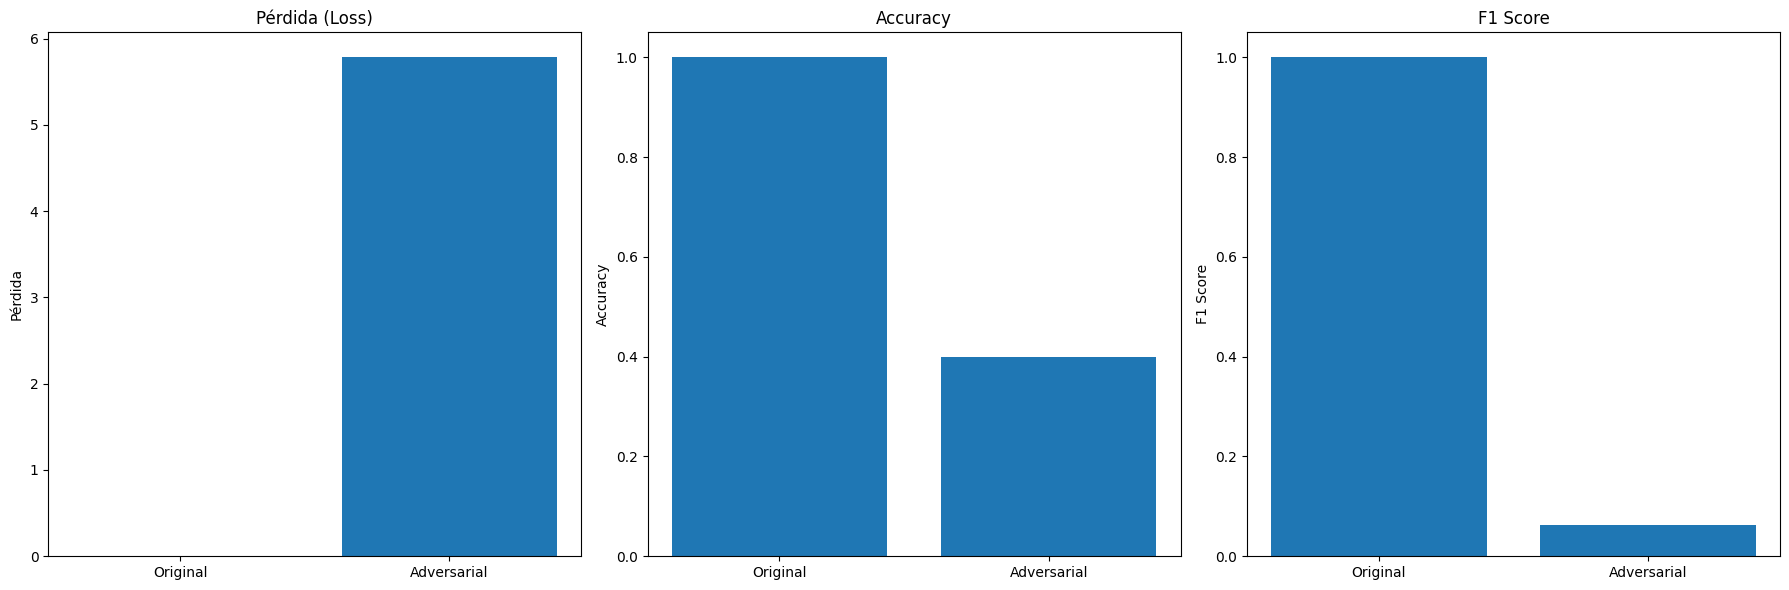

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Convertir los resultados a arrays numpy para análisis posterior
original_predictions = np.array(original_predictions).flatten()
adversarial_predictions = np.array(adversarial_predictions).flatten()

# Calcular la pérdida y el accuracy para las predicciones originales y adversarias
y_test_sampled = y_test.iloc[:num_samples].values

loss_original = loss_object(y_test_sampled, original_predictions).numpy()
loss_adversarial = loss_object(y_test_sampled, adversarial_predictions).numpy()

accuracy_original = np.mean((original_predictions > 0.5).astype(int) == y_test_sampled)
accuracy_adversarial = np.mean((adversarial_predictions > 0.5).astype(int) == y_test_sampled)

# Calcular el F1 Score
f1_original = f1_score(y_test_sampled, (original_predictions > 0.5).astype(int))
f1_adversarial = f1_score(y_test_sampled, (adversarial_predictions > 0.5).astype(int))

print("Pérdida original:", loss_original)
print("Pérdida adversaria:", loss_adversarial)
print("Accuracy original:", accuracy_original)
print("Accuracy adversaria:", accuracy_adversarial)
print("F1 Score original:", f1_original)
print("F1 Score adversaria:", f1_adversarial)

# Graficar los resultados
plt.figure(figsize=(18, 6))

# Pérdida
plt.subplot(1, 3, 1)
plt.bar(['Original', 'Adversarial'], [loss_original, loss_adversarial])
plt.title('Pérdida (Loss)')
plt.ylabel('Pérdida')

# Accuracy
plt.subplot(1, 3, 2)
plt.bar(['Original', 'Adversarial'], [accuracy_original, accuracy_adversarial])
plt.title('Accuracy')
plt.ylabel('Accuracy')

# F1 Score
plt.subplot(1, 3, 3)
plt.bar(['Original', 'Adversarial'], [f1_original, f1_adversarial])
plt.title('F1 Score')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()